# Scipy CWT scaleogram variants

This builds on "Introduction to signal transformation", using scipy.signal for continuous wavelet transformation, then exploring how the scaleograms produced vary with changes to the cwt parameters and signal characteristics. This includes:
* Changing the wavelet scale (higher, lower, decimal, log)
* Changing the signal scale (higher, lower, adjusted by 140bpm, normalised)
* Smoothing the signal (DWT, rolling mean)
* Using signals with known abnormalities

## Notebook set-up

In [1]:
# Import packages
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
from scipy import signal

In [2]:
# Import example of a FHR and UCR to be used in notebook (FHR cleaned, UC not)
fhr = pd.read_csv('data_fhr_clean/1001.csv')['FHR']
ctg = pd.read_csv('data_csv/1001.csv')
uc = ctg['UC']

## Define function for varying CWT

In [3]:
def cwt_plot(sig_ax,
             cwt_ax,
             scales=np.arange(1, 31),
             sig=fhr,
             sig_title='FHR',
             cwt_title='CWT of signal',
             cwt_yaxis_lab='FHR (bpm)'):
    '''
    Plot the signal, perform CWT and then plot the scaleogram
    Inputs:
    - sig_ax - axis to plot the signal onto
    - cwt_ax - axis to plot the scaleogram onto
    - scales - array containing each of the wavelet scales to use
    - sig - series, contains the time-series/signal to input
    - sig_title - string, title for the signal plot
    - cwt_title - string, title for scaleogram
    - cwt_yaxis_lab - string, label for scaleogram y axis
    '''
    # Plot FHR
    sig_ax.plot(sig)
    sig_ax.margins(x=0)
    sig_ax.set_title(sig_title)
    sig_ax.set_xlabel('Time (quarter of a second)')
    sig_ax.set_ylabel(cwt_yaxis_lab)

    # Perform CWT
    cwtmatr = signal.cwt(sig, signal.morlet2, scales)

    # Plot the scaleogram
    magn = np.absolute(cwtmatr)
    im = cwt_ax.imshow(
        magn,
        extent=[min(sig.index), max(sig.index), scales.min(), scales.max()],
        aspect='auto',
    )
    cwt_ax.set_xlabel('Time (quarter of a second)')
    cwt_ax.set_ylabel('Wavelet scale (inverse of frequency)')
    cwt_ax.set_title(cwt_title)
    plt.colorbar(im, ax=cwt_ax, orientation='horizontal', aspect=8)

## Increasing the maximum wavelet scale

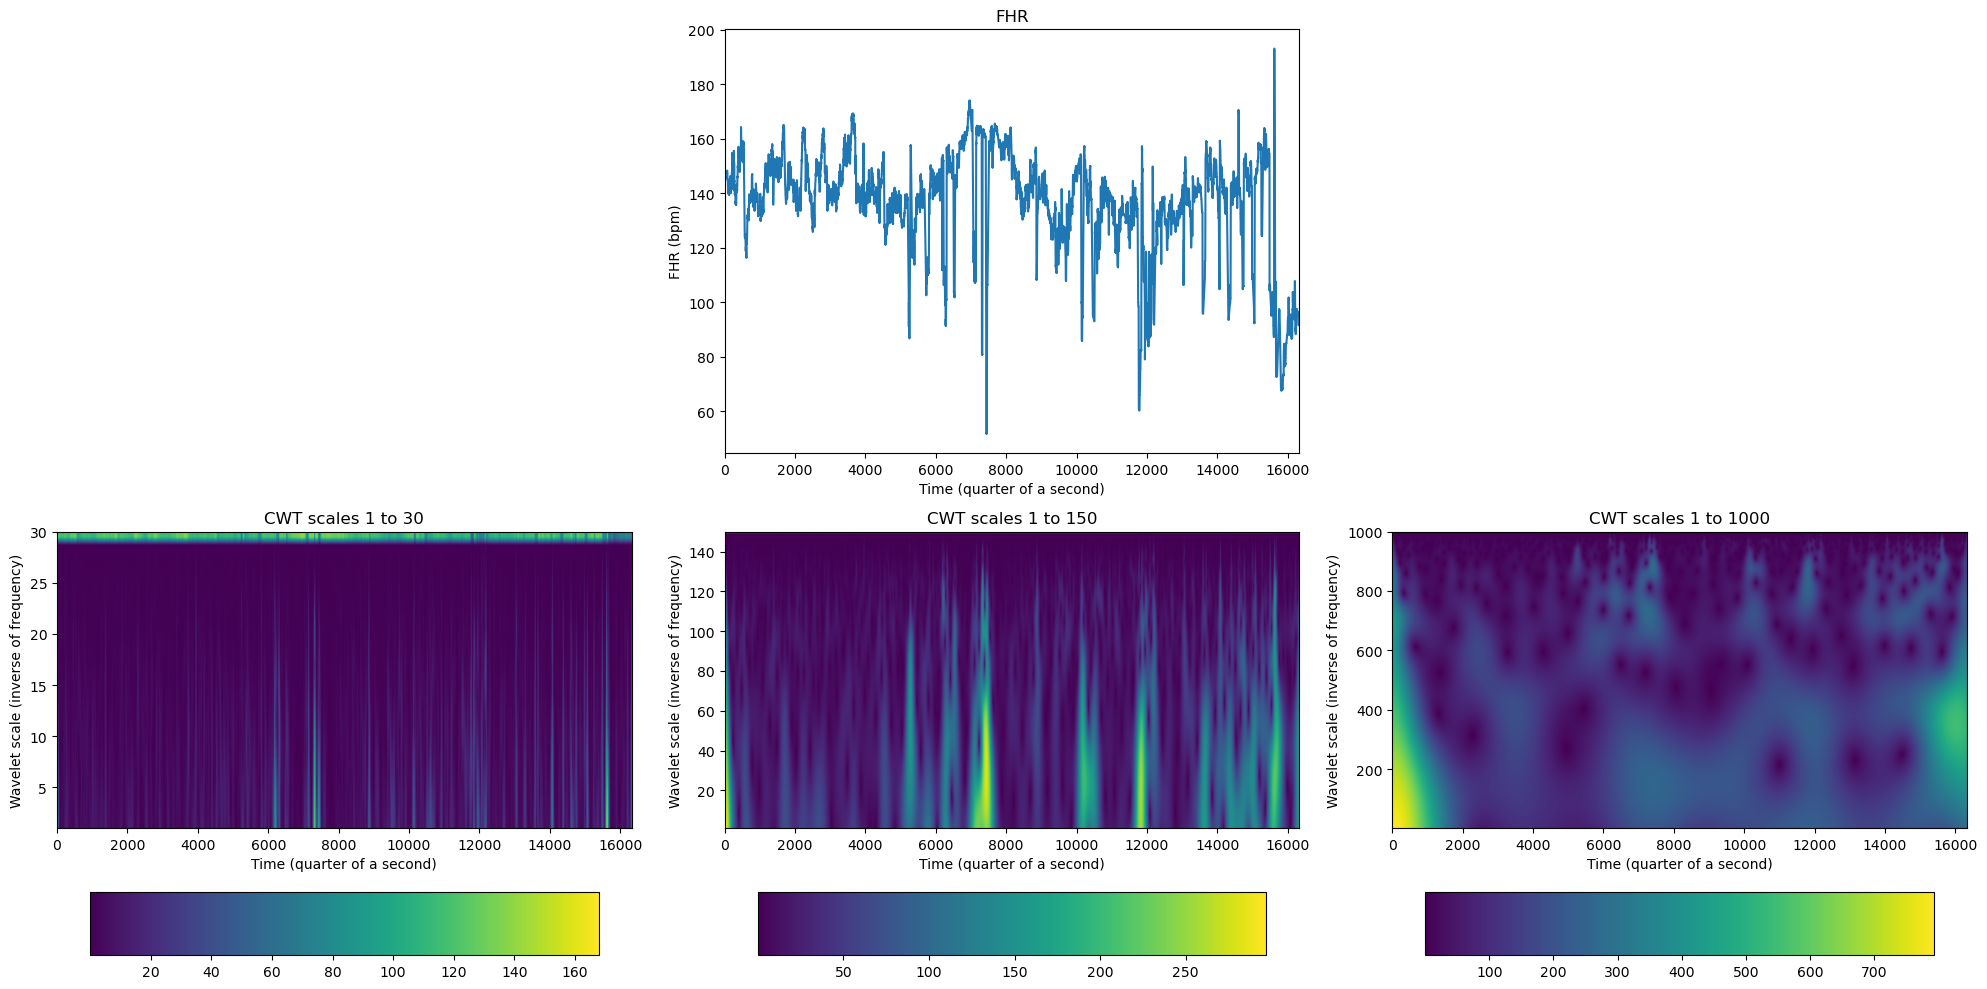

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

cwt_plot(ax[0,0], ax[1,0], scales=np.arange(1, 31), cwt_title='CWT scales 1 to 30')
cwt_plot(ax[0,1], ax[1,1], scales=np.arange(1, 151), cwt_title='CWT scales 1 to 150')
cwt_plot(ax[0,2], ax[1,2], scales=np.arange(1, 1001), cwt_title='CWT scales 1 to 1000')

fig.delaxes(ax[0,0])
fig.delaxes(ax[0,2])

plt.tight_layout()
plt.show()

By increasing the maximum wavelet scale, this should mean we are therefore looking for lower frequencies.

**Observations** - as we increase the range of scales:
* Lose bar of colour from top of chart
* Increased presence of boundary effects - "As the frequency decreases, the width of the CWT coefficients in time that are nonzero and centered on the impulse increases. Conversely, as the frequency increases, the width of the CWT coefficients that are nonzero decreases and becomes increasingly centered on the impulse. Low frequencies correspond to wavelets of longer scale, while higher frequencies correspond to wavelets of shorter scale. The effect of the impulse persists longer in time with longer wavelets. In other words, the longer the wavelet, the longer the duration of influence of the signal. For a wavelet centered at a certain point in time, stretching or shrinking the wavelet results in the wavelet "seeing" more or less of the signal. This is referred to as the wavelet's cone of influence."[[source]](https://uk.mathworks.com/help/wavelet/ug/boundary-effects-and-the-cone-of-influence.html)
* Lose time specificity

**Resulting questions:**
* Does the loss of the bar of colour mean we were previously setting the maximum scale too low?
* How problematic are boundary effects?
* Can we plot the cone of influence in python?

**Below** is the seperating out ranges from 1 to 150 into 3...

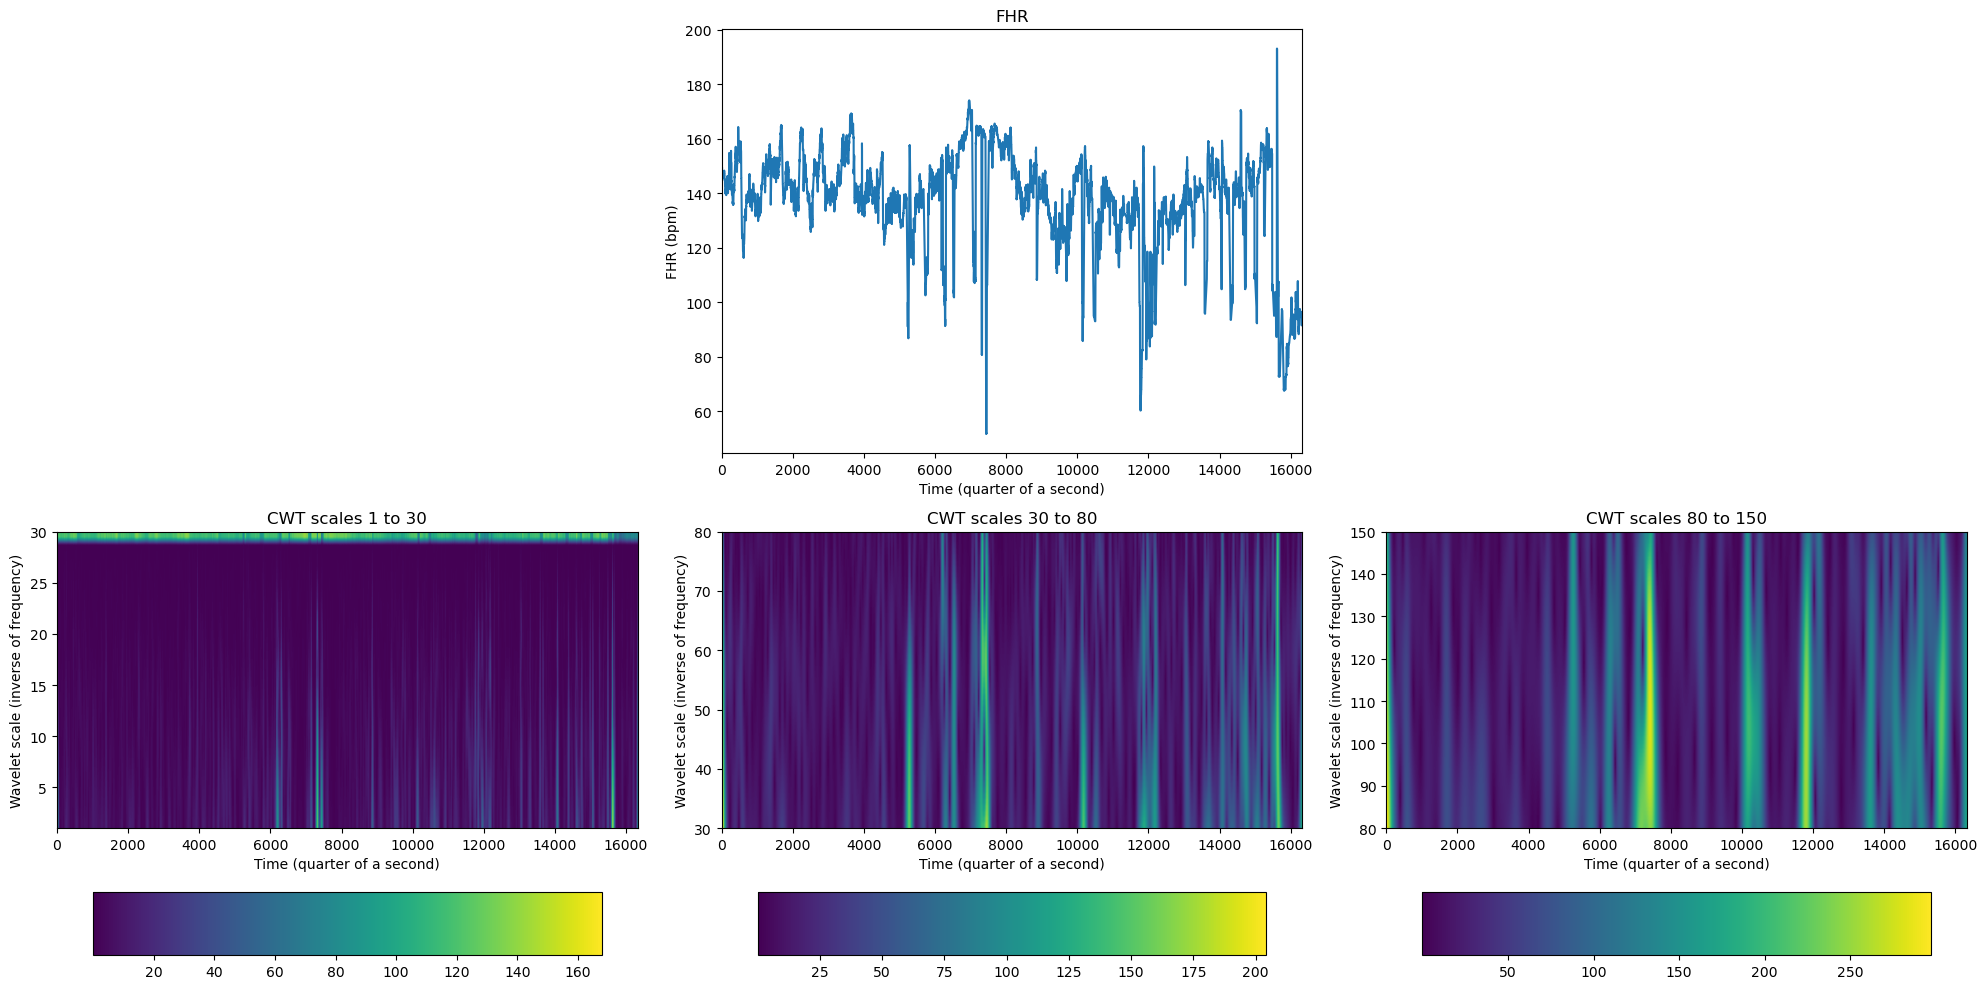

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

cwt_plot(ax[0,0], ax[1,0], scales=np.arange(1, 31), cwt_title='CWT scales 1 to 30')
cwt_plot(ax[0,1], ax[1,1], scales=np.arange(30, 81), cwt_title='CWT scales 30 to 80')
cwt_plot(ax[0,2], ax[1,2], scales=np.arange(80, 151), cwt_title='CWT scales 80 to 150')

fig.delaxes(ax[0,0])
fig.delaxes(ax[0,2])

plt.tight_layout()
plt.show()

## Using decimal scales

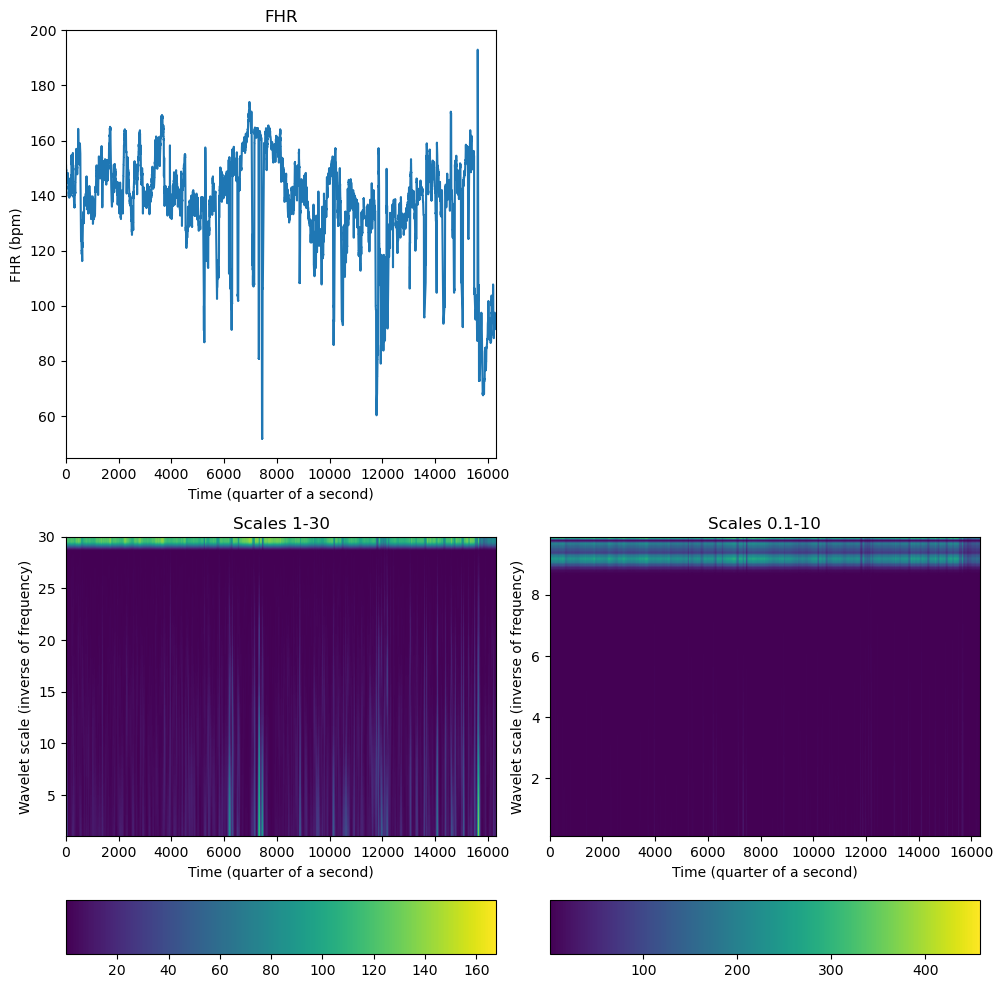

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

cwt_plot(ax[0,0], ax[1,0], cwt_title='Scales 1-30')
cwt_plot(ax[0,1], ax[1,1],
         scales=np.arange(0.1, 10, 0.1),
         cwt_title='Scales 0.1-10')

fig.delaxes(ax[0,1])

plt.tight_layout()
plt.show()

**Observations**:
* Blank - presuming that those scales are too small

## Using log scales

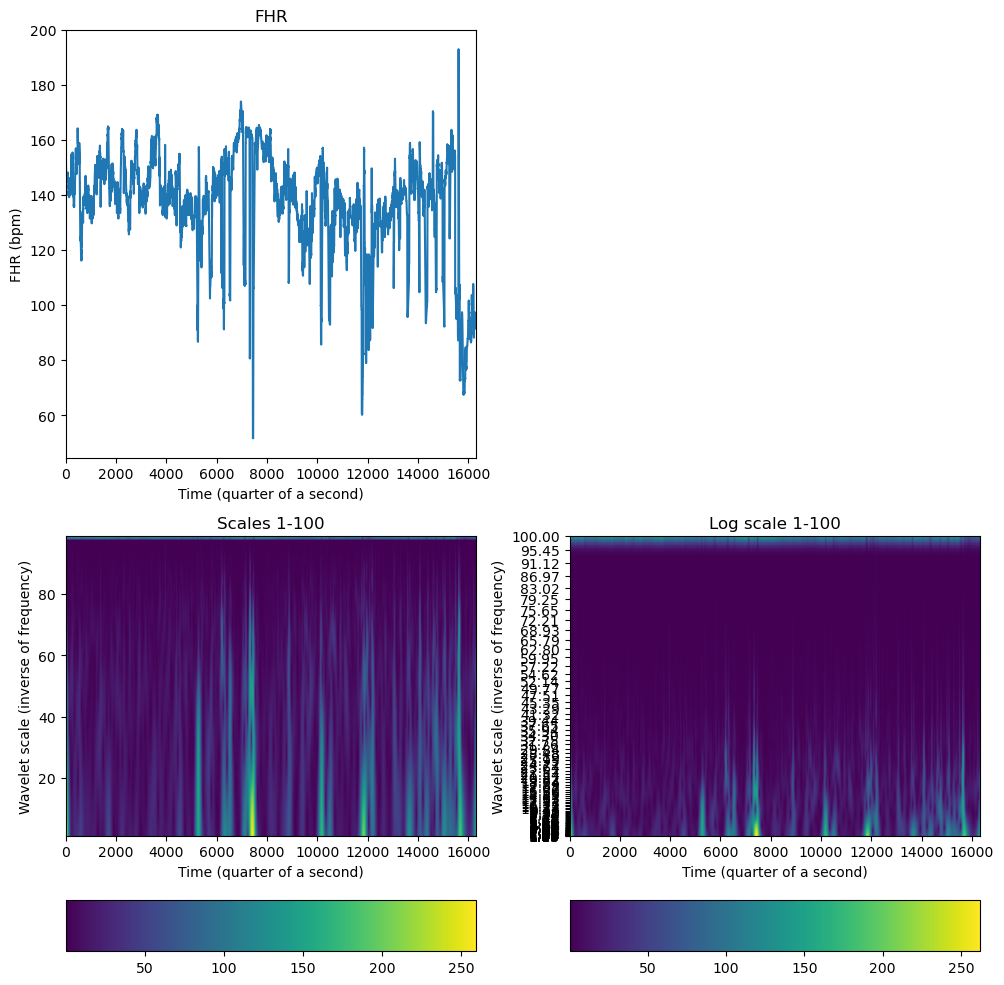

In [7]:
# Generate a log scale from 1 to 100
log_scale = np.logspace(0, 2, num=100)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

cwt_plot(ax[0,0], ax[1,0], scales=np.arange(1, 100, 1), cwt_title='Scales 1-100')
cwt_plot(ax[0,1], ax[1,1], scales=log_scale, cwt_title='Log scale 1-100')
ax[1,1].set_yticks(log_scale)

fig.delaxes(ax[0,1])

plt.tight_layout()
plt.show()

Not sure if I've correctly created the figure, as it might be that the log scale labels are like "categorical" labels and should be equally spaced.

Observations:
* Makes the colours appear shorter

## Changing the units of the signal

### Adding a constant

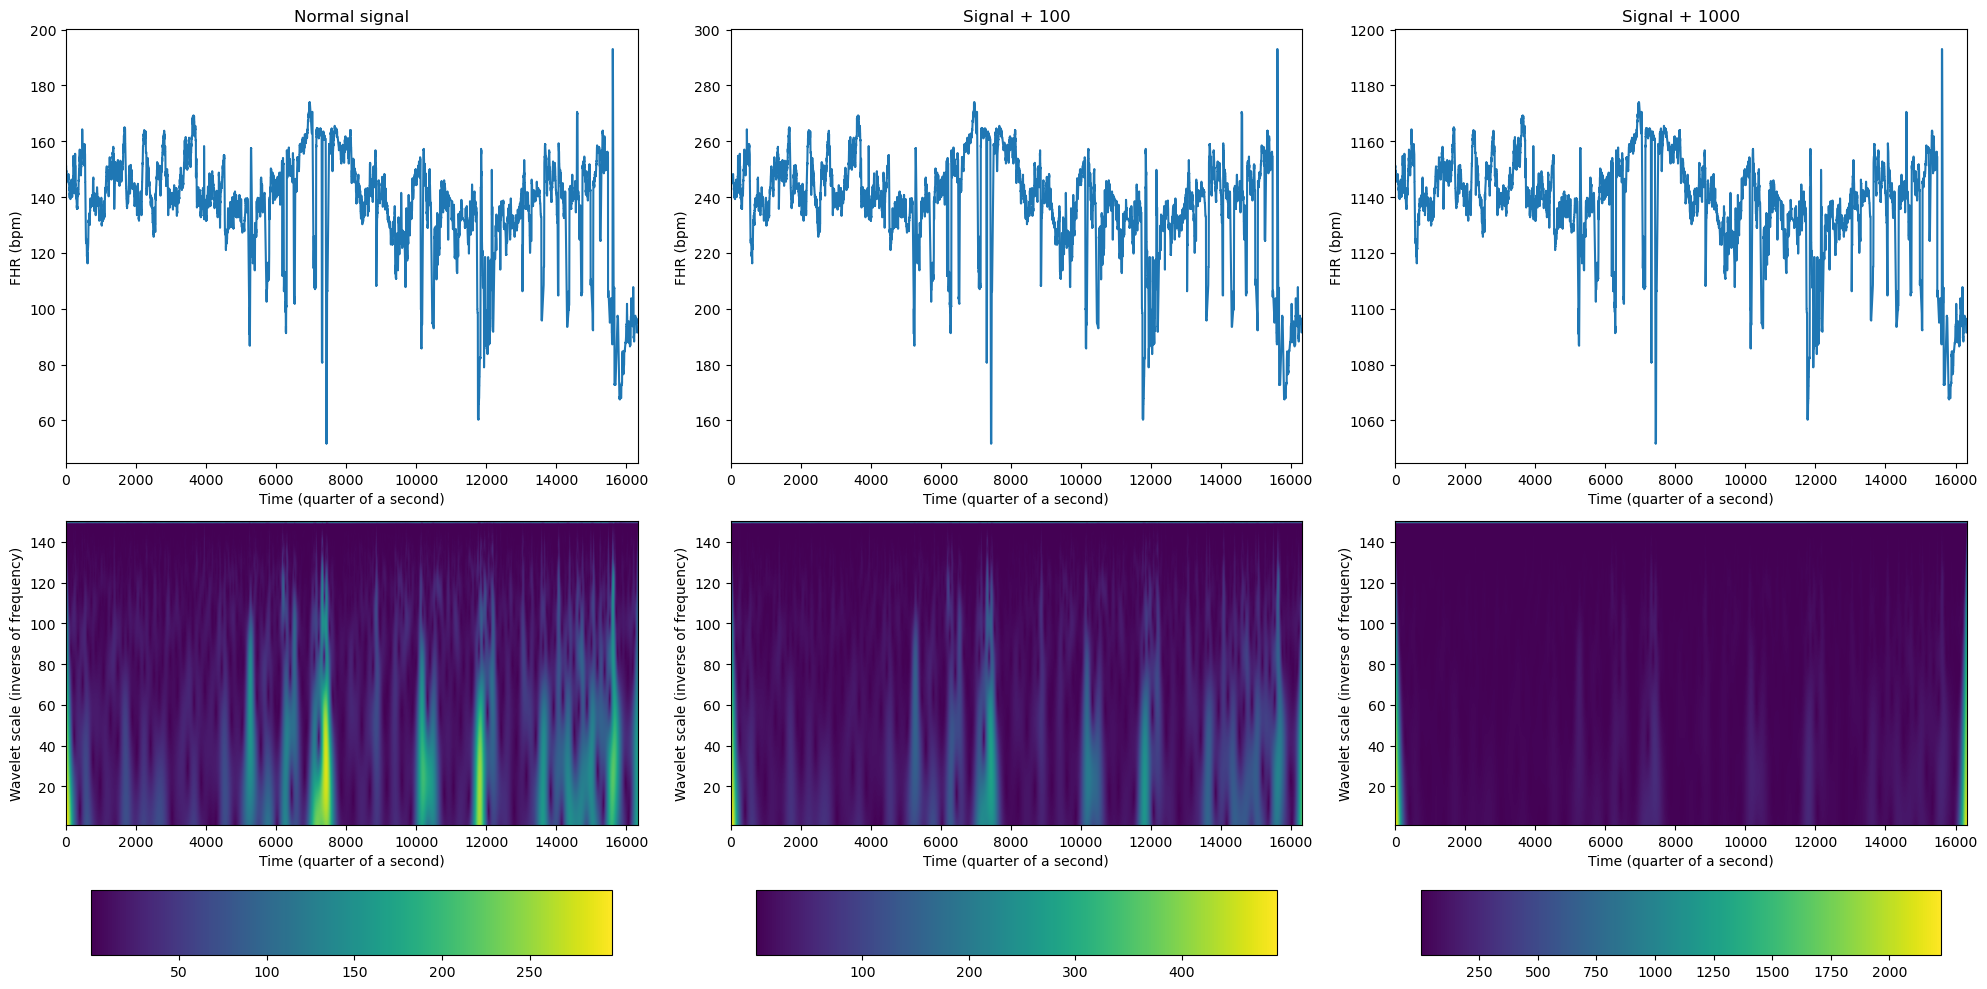

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

cwt_plot(ax[0,0], ax[1,0], sig=fhr, scales=np.arange(1, 151),
         sig_title='Normal signal', cwt_title='')
cwt_plot(ax[0,1], ax[1,1], sig=fhr+100, scales=np.arange(1, 151),
         sig_title='Signal + 100', cwt_title='')
cwt_plot(ax[0,2], ax[1,2], sig=fhr+1000, scales=np.arange(1, 151),
         sig_title='Signal + 1000', cwt_title='')

plt.tight_layout()
plt.show()

In this example, a constant has been added to the signal

**Observations**:
* **Impacts the scaleogram** - contrary to our expectations that signal scale wouldn't matter, as we had assumed it was just about the shape of the signal
* **Obvious edge-effect artifacts** these are areas where "the stretched wavelets extend beyond the edges of the observation interval". You could draw a cone of influence which would be in the two bottom corners of the figure, and in those, you should be suspicious about edge effects and understand that these may not be an accurate time-frequency representation of the data. These are also referred to as boundary effects.[[source]](https://uk.mathworks.com/help/wavelet/ug/boundary-effects-and-the-cone-of-influence.html)

**Questions**
* Why does this have such a large impact on results? The units used (bpm) aren't exactly meaningful?
* Do the boundary effects occur because the CWT assumes that we're using a periodic signal where, if we repeated the signal periodically, there would be a big jump between the start and end value, causing high amplitude in image?[[source]](https://stackoverflow.com/questions/43787412/strange-behaviour-of-cwt-at-the-end-and-the-beginning-in-matlab)

### Subtracting a constant

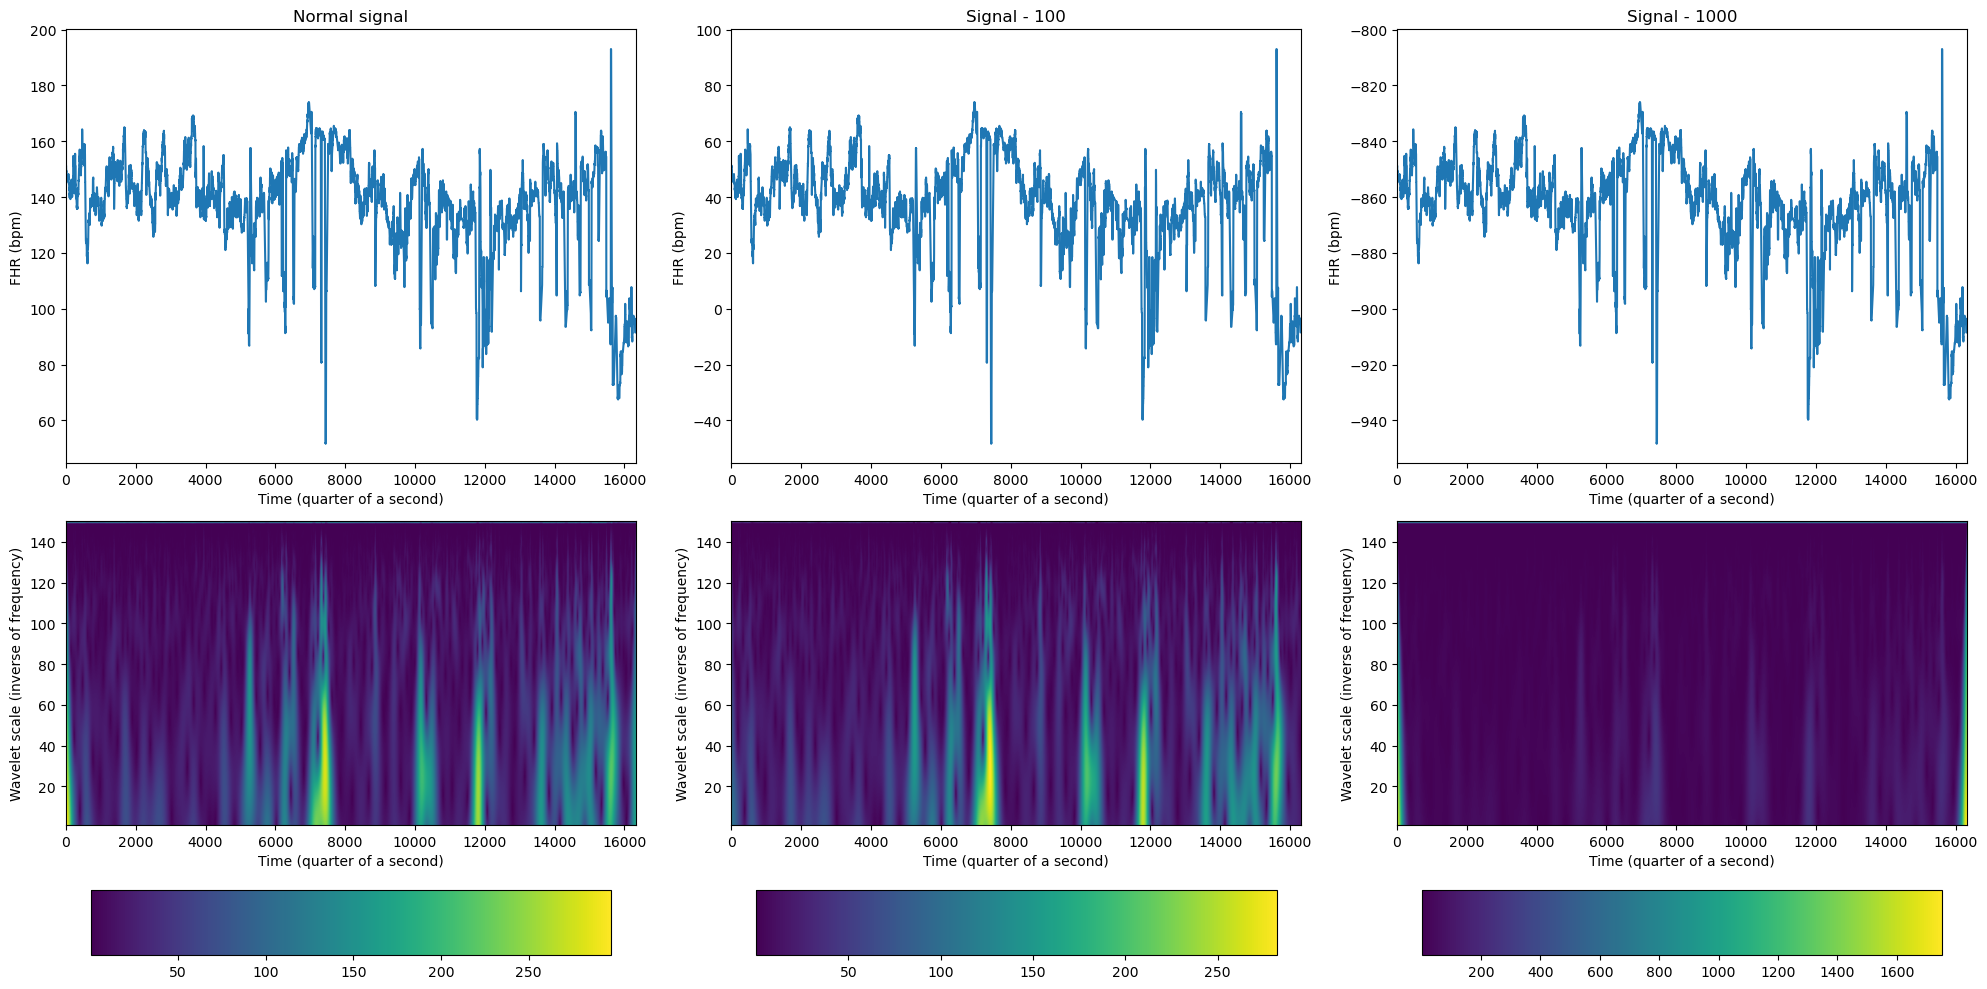

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

cwt_plot(ax[0,0], ax[1,0], sig=fhr, scales=np.arange(1, 151),
         sig_title='Normal signal', cwt_title='')
cwt_plot(ax[0,1], ax[1,1], sig=fhr-100, scales=np.arange(1, 151),
         sig_title='Signal - 100', cwt_title='')
cwt_plot(ax[0,2], ax[1,2], sig=fhr-1000, scales=np.arange(1, 151),
         sig_title='Signal - 1000', cwt_title='')

plt.tight_layout()
plt.show()

In these examples, a constant is subtracted from the signal

**Observations**:
* When we subtract 100, we actually seem to lose some of the boundary effects

### Centering or normalising the signal

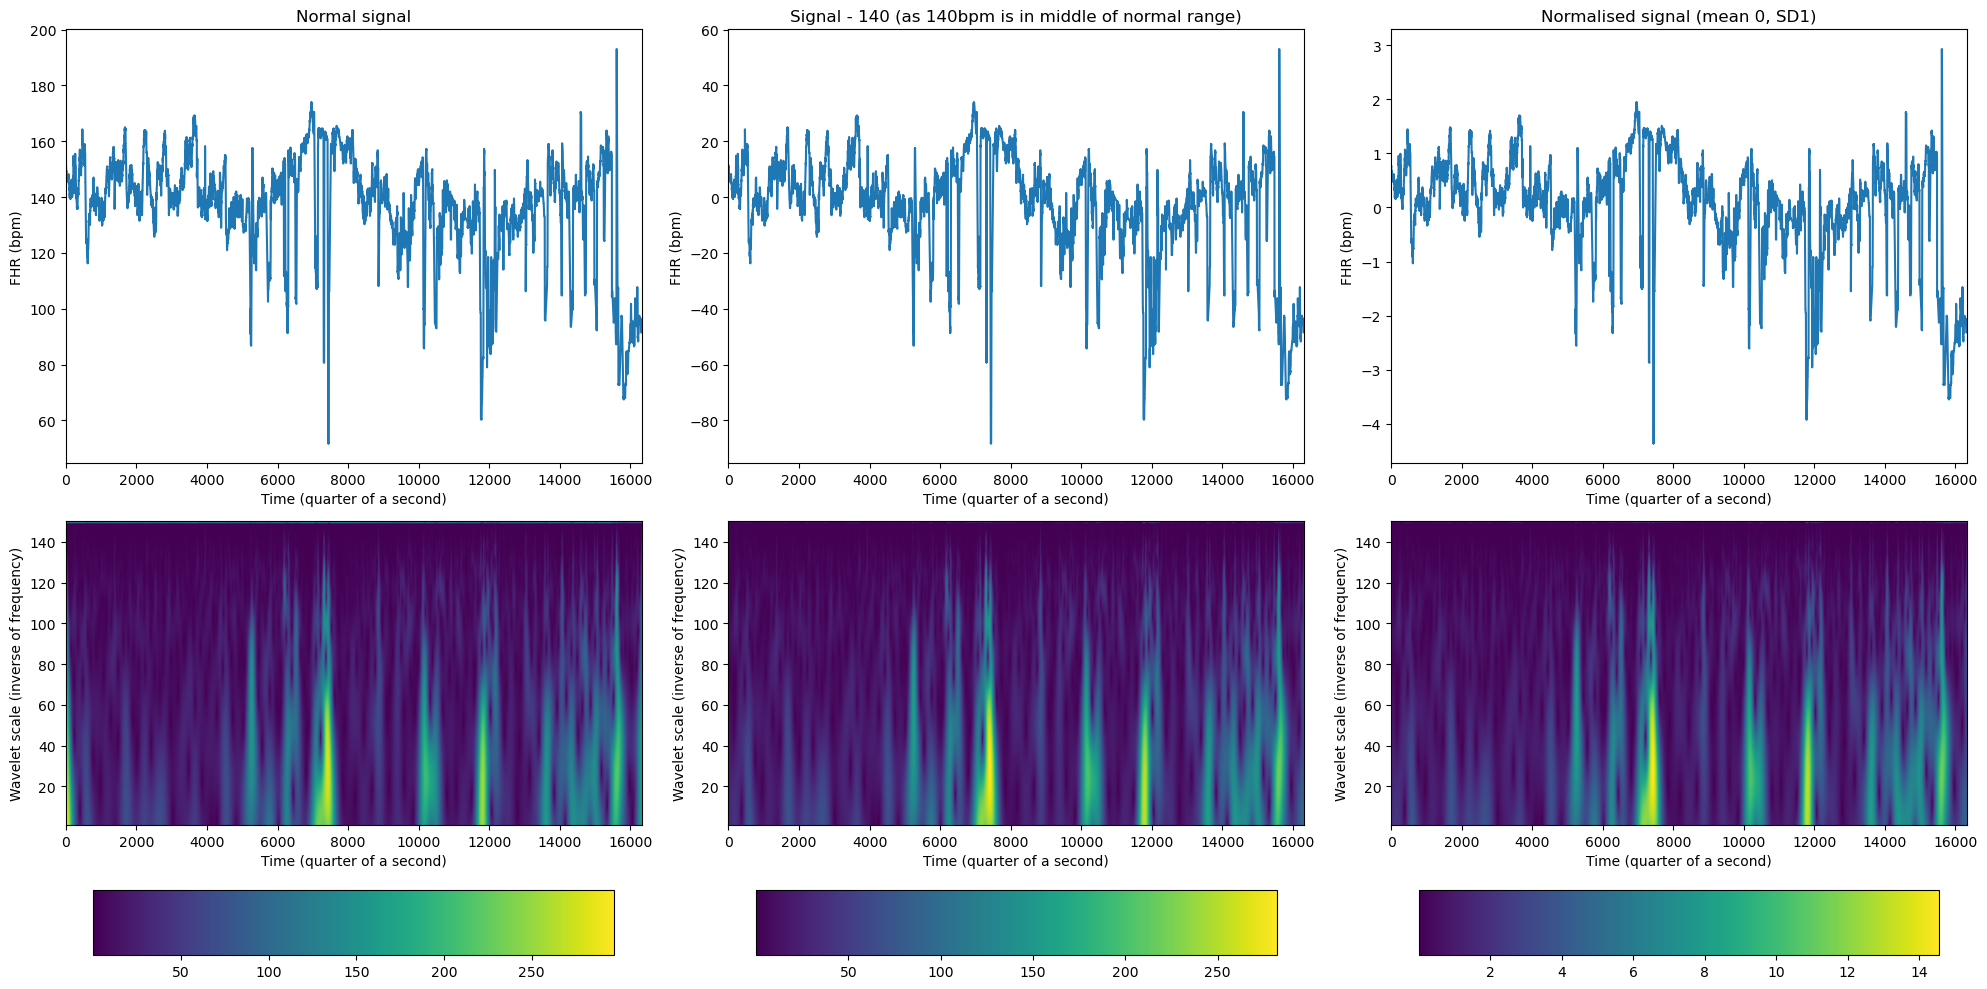

In [10]:
# Normalised signal
fhr_mean = fhr.mean()
fhr_sd = fhr.std()
fhr_norm = (fhr - fhr_mean) / fhr_sd

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

cwt_plot(ax[0,0], ax[1,0], sig=fhr, scales=np.arange(1, 151),
         sig_title='Normal signal', cwt_title='')
cwt_plot(ax[0,1], ax[1,1], sig=fhr-140, scales=np.arange(1, 151),
         sig_title='Signal - 140 (as 140bpm is in middle of normal range)', cwt_title='')
cwt_plot(ax[0,2], ax[1,2], sig=fhr_norm, scales=np.arange(1, 151),
         sig_title='Normalised signal (mean 0, SD1)', cwt_title='')

plt.tight_layout()
plt.show()

I tried two scenarios:
* Subtracting 140 (as 140bpm is in the middle of the normal FHR range)
* Normalising the signal to have mean 0 and SD 1 (although we wouldn't actually want to do this, as scale is important - it can indicate that a fetus is experiencing unusually low or high rate overall)

**Observations**:
* Normalised and subtraction of 140bpm appear to produce quite similar results

**Below** I repeat but with a smaller range of scales...

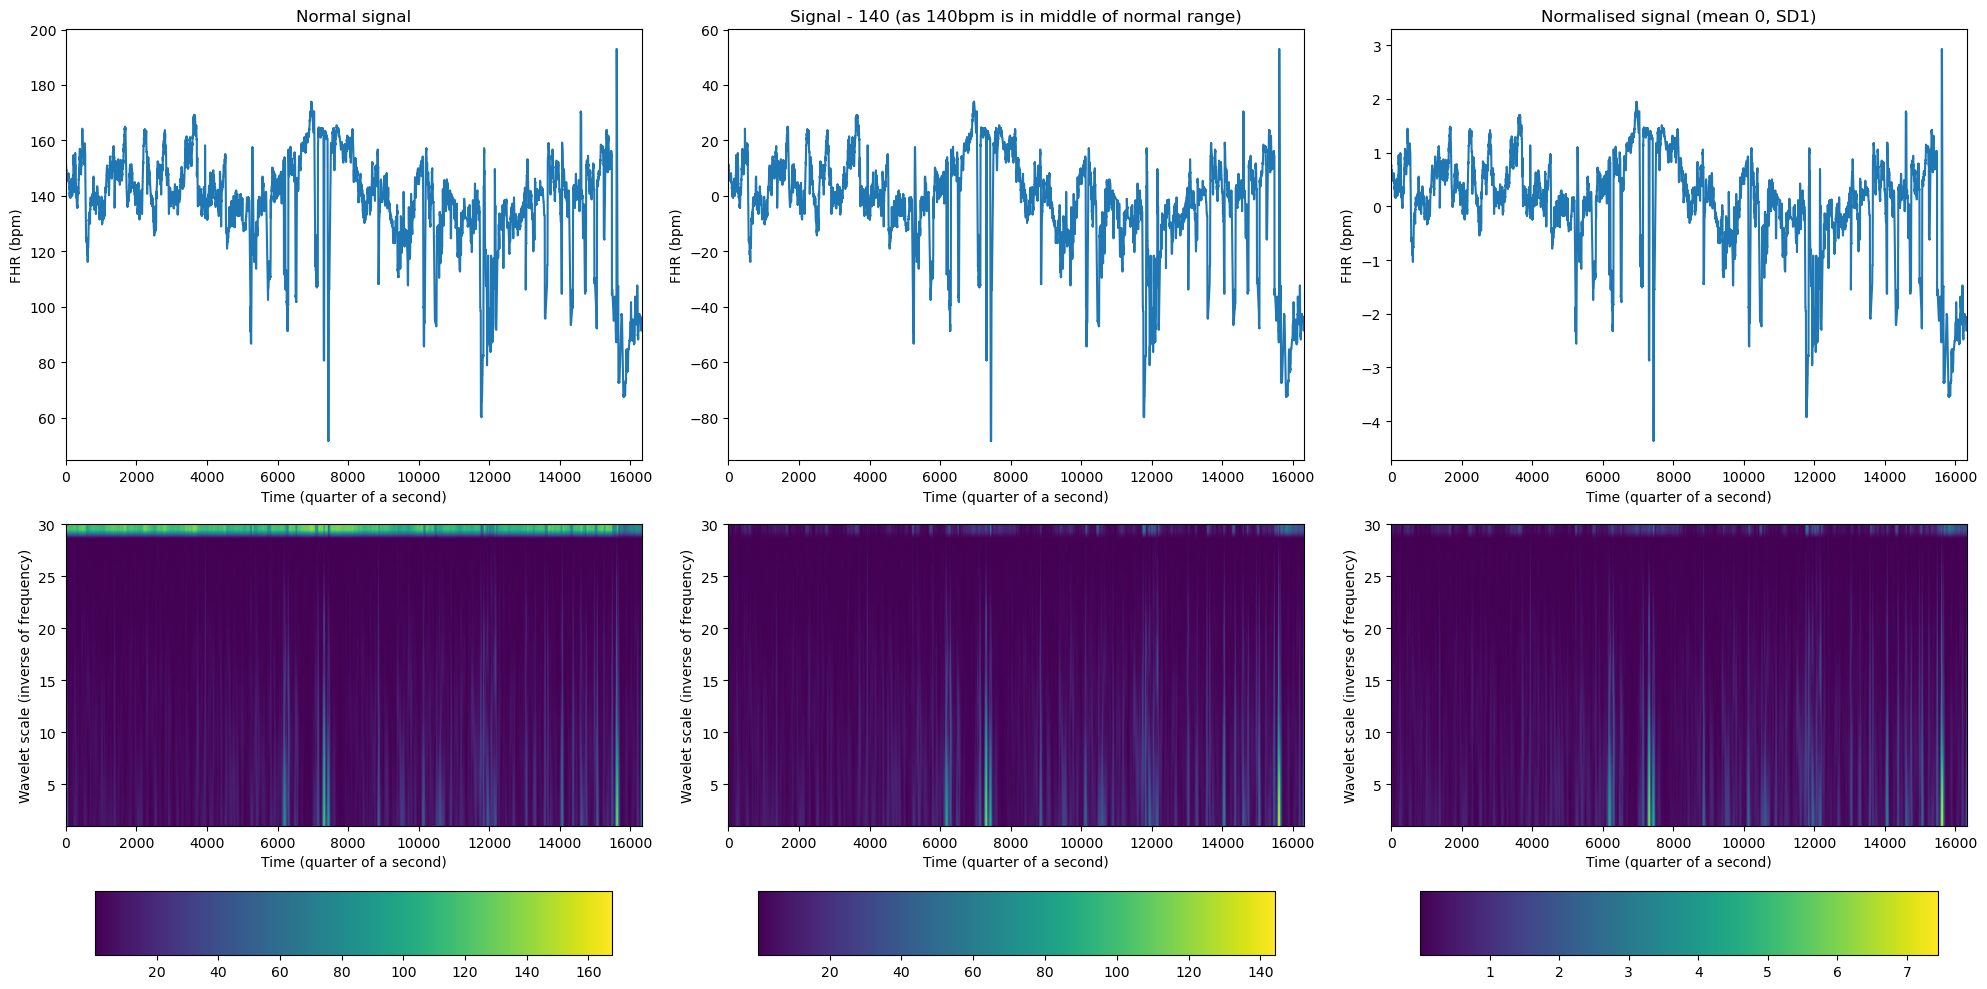

In [11]:
# Normalised signal
fhr_mean = fhr.mean()
fhr_sd = fhr.std()
fhr_norm = (fhr - fhr_mean) / fhr_sd

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

cwt_plot(ax[0,0], ax[1,0], sig=fhr, scales=np.arange(1, 31),
         sig_title='Normal signal', cwt_title='')
cwt_plot(ax[0,1], ax[1,1], sig=fhr-140, scales=np.arange(1, 31),
         sig_title='Signal - 140 (as 140bpm is in middle of normal range)', cwt_title='')
cwt_plot(ax[0,2], ax[1,2], sig=fhr_norm, scales=np.arange(1, 31),
         sig_title='Normalised signal (mean 0, SD1)', cwt_title='')

plt.tight_layout()
plt.show()

## Smoothing the signal

Using linear scales to 150

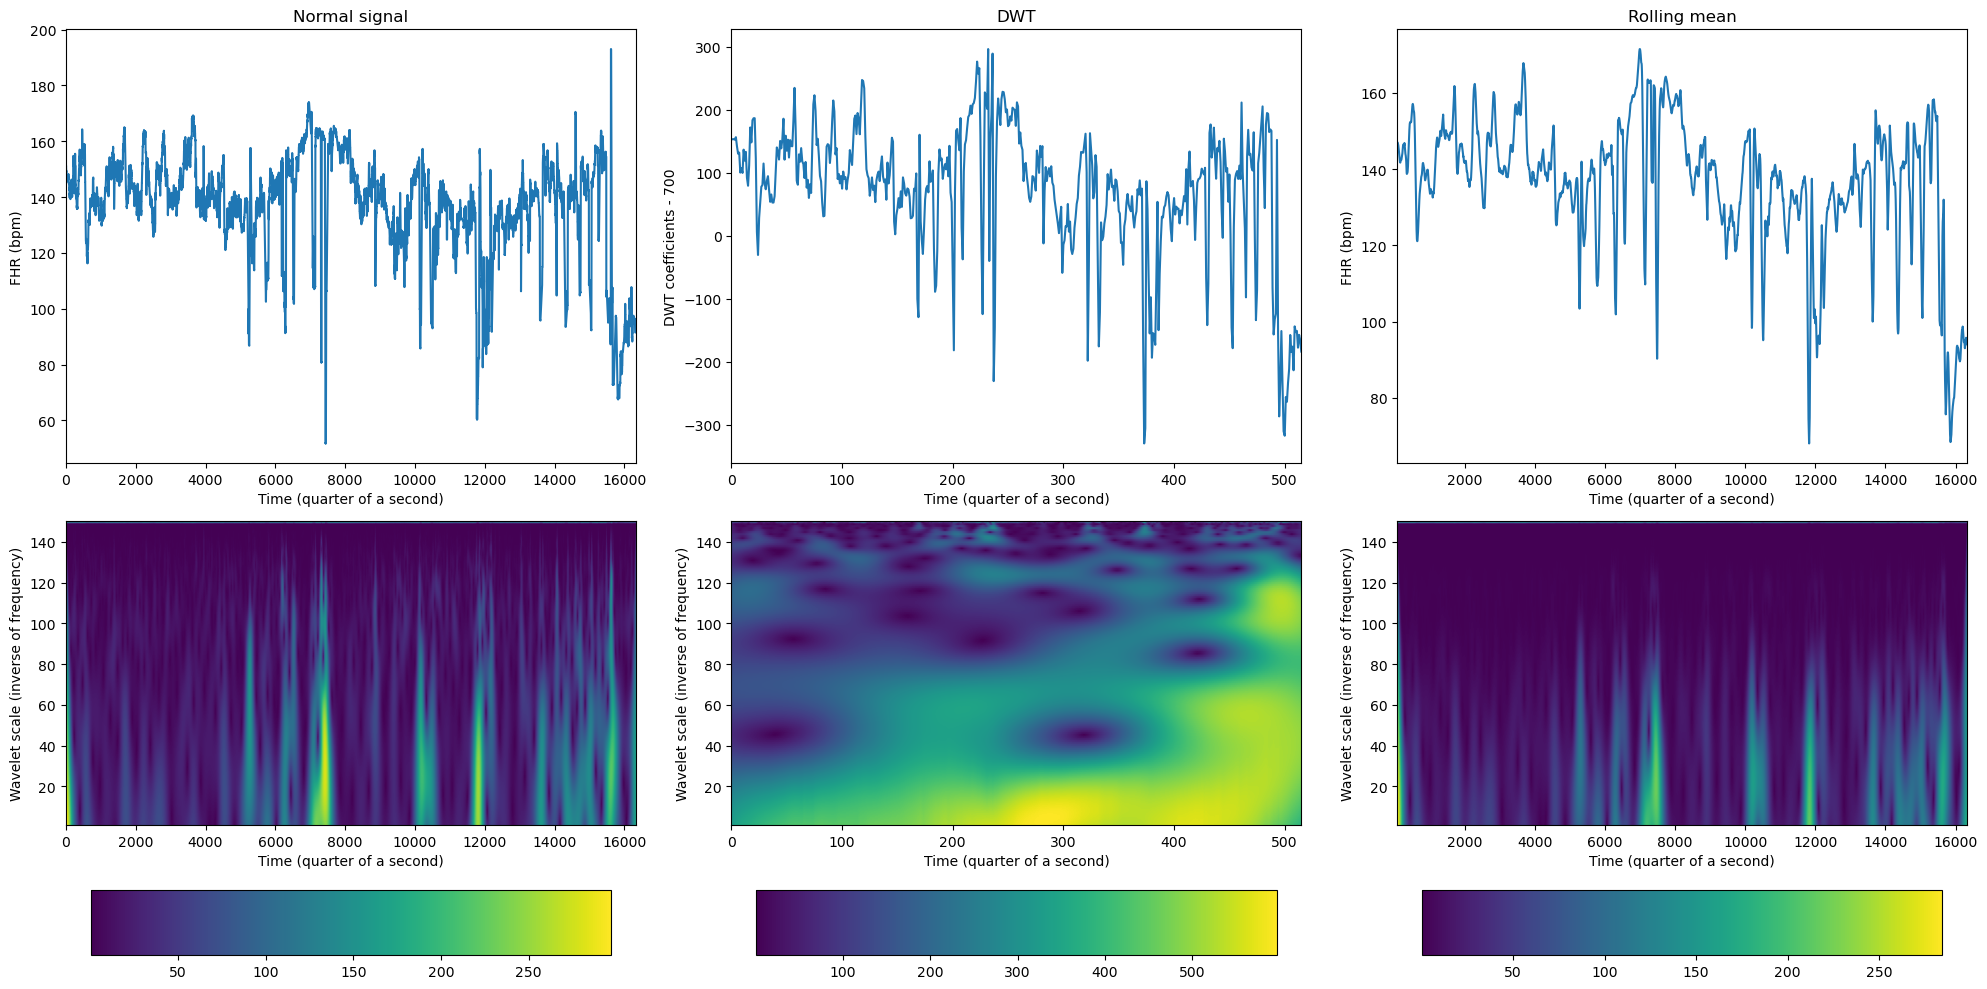

In [12]:
# Perform DWT and take first wavelet
wavelets = pywt.wavedec(fhr, 'db4', level=5)
dwt_fhr = wavelets[0]

# Rolling mean
rolling = fhr.rolling(window=60).mean().dropna()

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

cwt_plot(ax[0,0], ax[1,0], sig=fhr, scales=np.arange(1, 151),
         sig_title='Normal signal', cwt_title='')
cwt_plot(ax[0,1], ax[1,1], sig=pd.Series(dwt_fhr)-700, scales=np.arange(1, 151),
         sig_title='DWT', cwt_title='', cwt_yaxis_lab='DWT coefficients - 700')
cwt_plot(ax[0,2], ax[1,2], sig=rolling, scales=np.arange(1, 151),
         sig_title='Rolling mean', cwt_title='')

plt.tight_layout()
plt.show()

Using log scales to 30

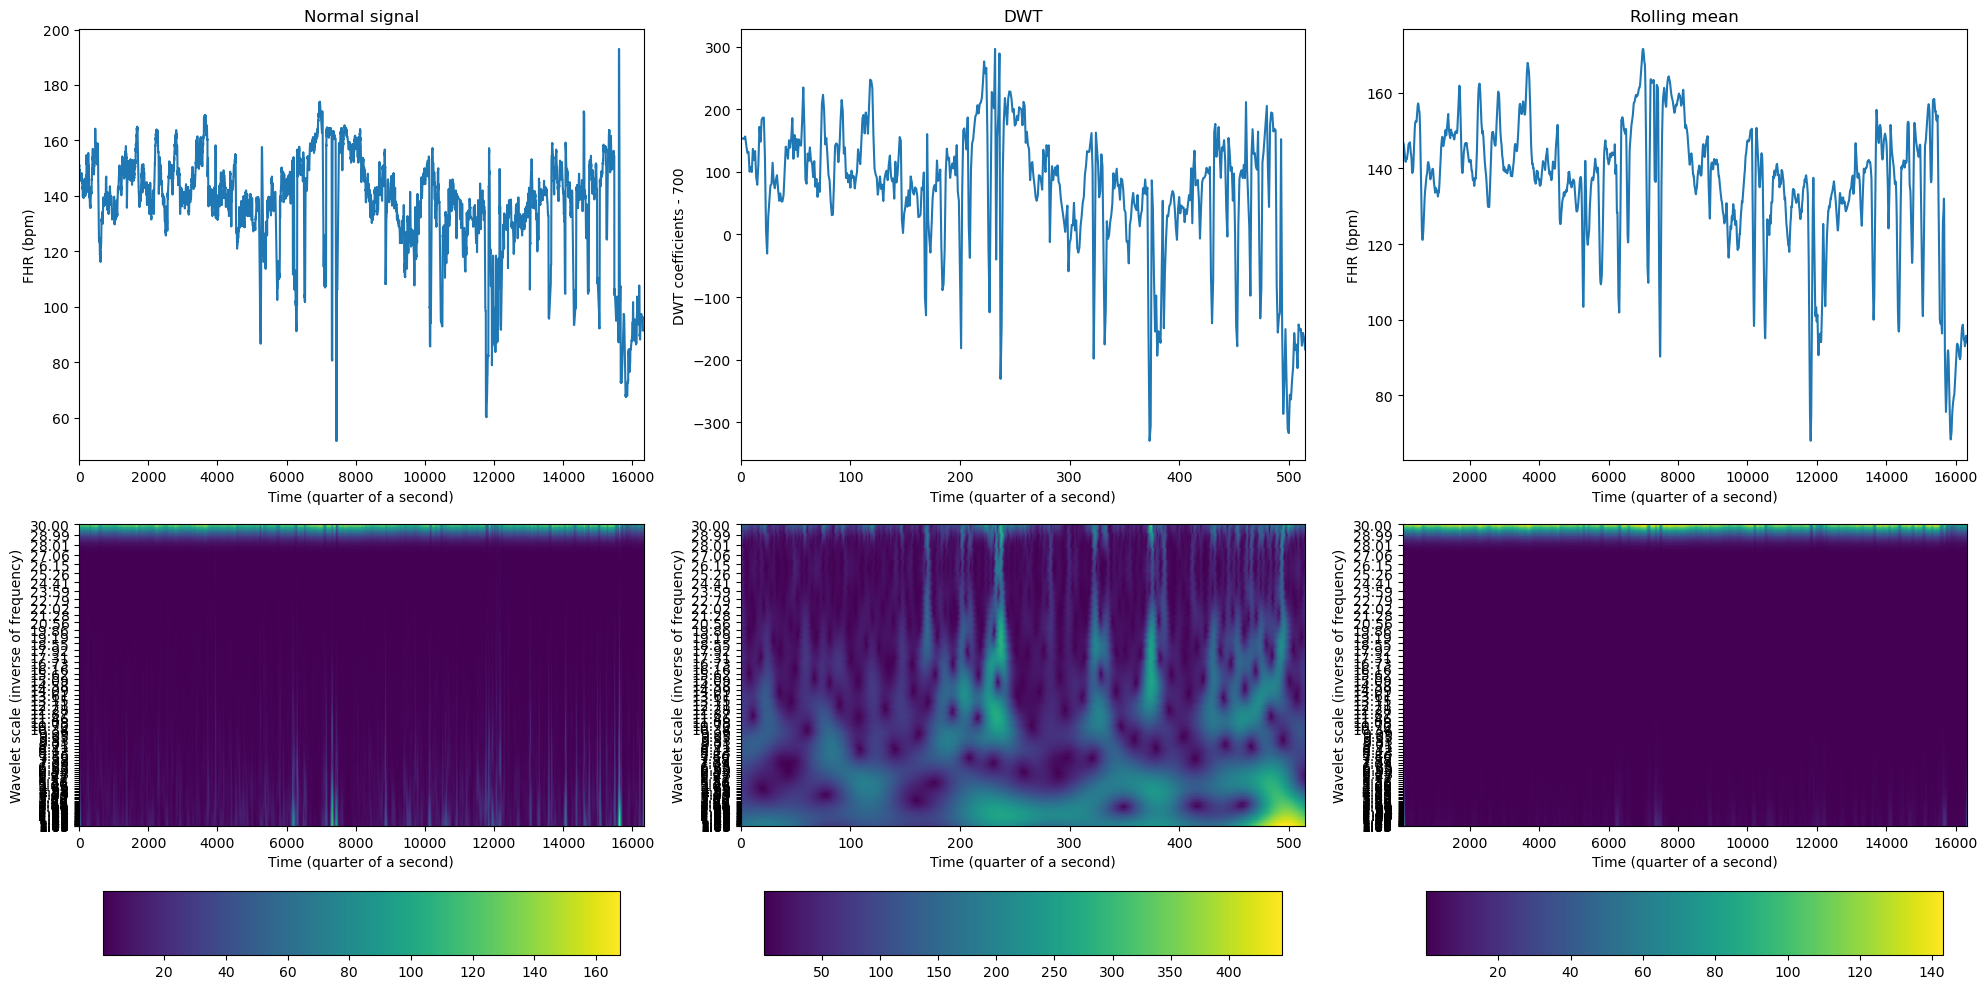

In [13]:
# Initialise figure and scale
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
log_scale = np.geomspace(start=1, stop=30, num=100)

# Standard
cwt_plot(ax[0,0], ax[1,0], sig=fhr, scales=log_scale,
         sig_title='Normal signal', cwt_title='')
ax[1,0].set_yticks(log_scale)

# Perform DWT and take first wavelet
wavelets = pywt.wavedec(fhr, 'db4', level=5)
dwt_fhr = wavelets[0]
cwt_plot(ax[0,1], ax[1,1], sig=pd.Series(dwt_fhr)-700, scales=log_scale,
         sig_title='DWT', cwt_title='', cwt_yaxis_lab='DWT coefficients - 700')
ax[1,1].set_yticks(log_scale)

# Rolling mean
rolling = fhr.rolling(window=60).mean().dropna()
cwt_plot(ax[0,2], ax[1,2], sig=rolling, scales=log_scale,
         sig_title='Rolling mean', cwt_title='')
ax[1,2].set_yticks(log_scale)

plt.tight_layout()
plt.show()

I tried two different methods of smoothing:
* Using DWT
* Taking a rolling average

**Observations**:
* DWT compressed the signal (note x axis 175) - and I think this loss of information has meant we lose information (either due to CWT length or or boundary effects or something similar)
* Taking a rolling mean seems to have had little impact on the results

## Using CWT on FHR records with known anomalies

Record 1001 (the first record which I used for everything above, not sure if there are any known anomalies present)

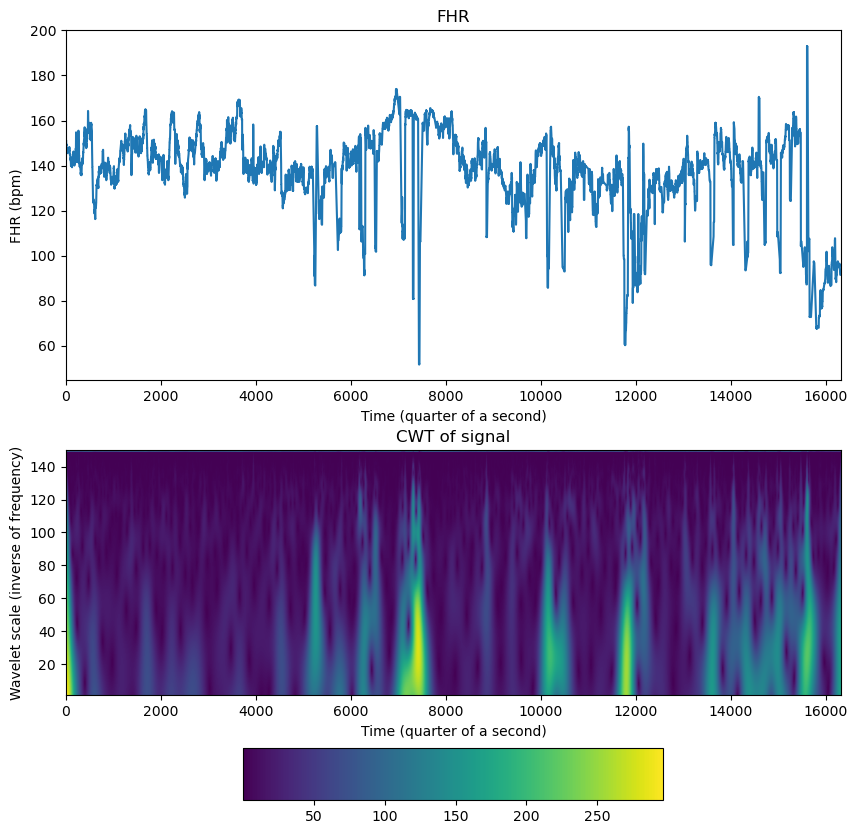

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
cwt_plot(ax[0], ax[1], scales=np.arange(1, 151), sig=fhr)

Record 1036 which has tachycardia (FHR faster than normal)

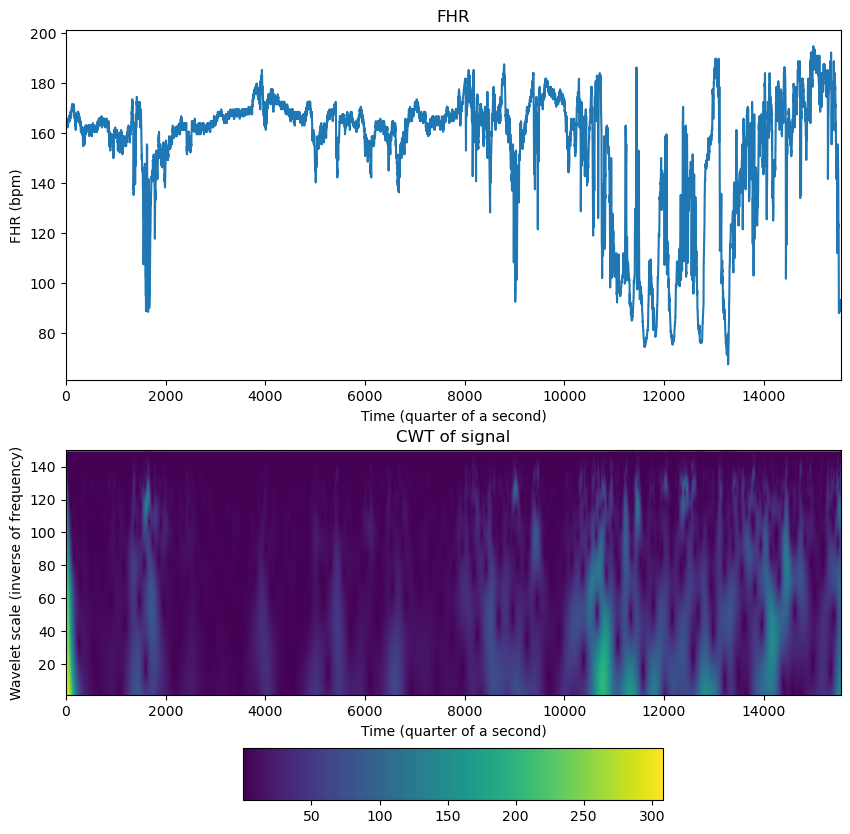

In [15]:
fhr_alt = pd.read_csv('data_fhr_clean/1036.csv')['FHR']
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
cwt_plot(ax[0], ax[1], scales=np.arange(1, 151), sig=fhr_alt)

Record 1317 which has bradychardia (FHR slower than normal)

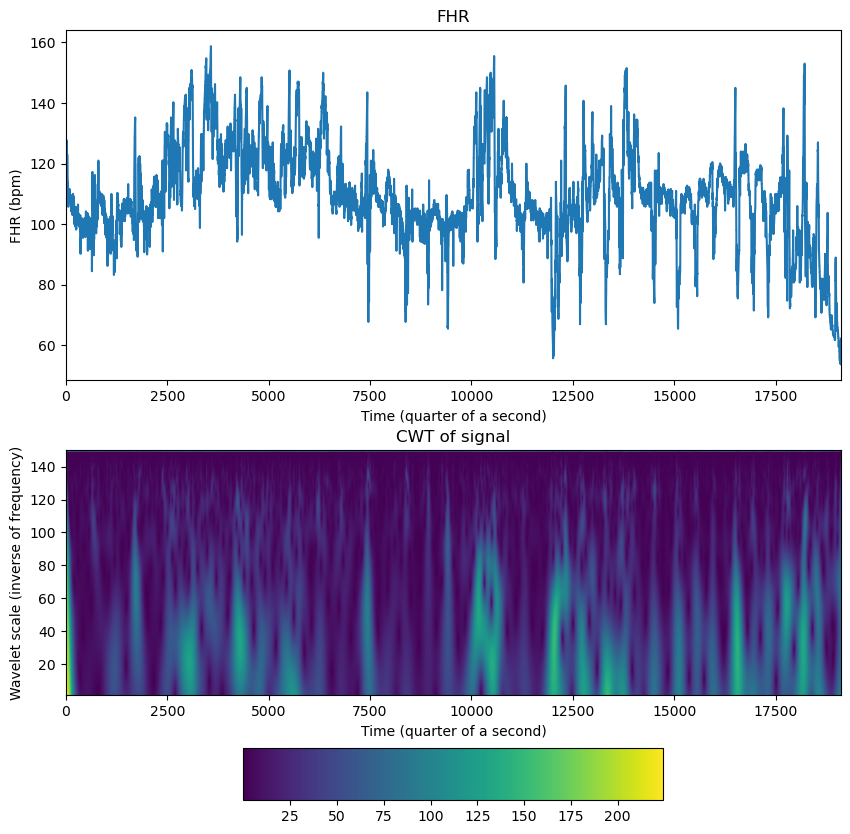

In [16]:
fhr_alt = pd.read_csv('data_fhr_clean/1317.csv')['FHR']
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
cwt_plot(ax[0], ax[1], scales=np.arange(1, 151), sig=fhr_alt)

Record 1176 which has accelerations and decelerations

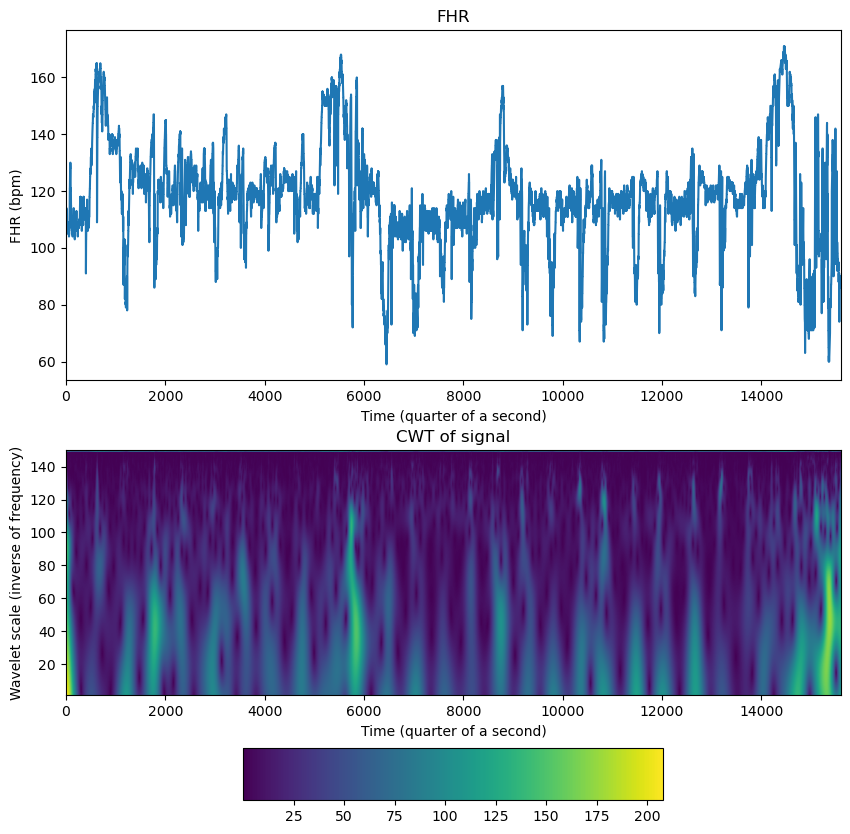

In [17]:
fhr_alt = pd.read_csv('data_fhr_clean/1176.csv')['FHR']
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
cwt_plot(ax[0], ax[1], scales=np.arange(1, 151), sig=fhr_alt)